<a href="https://colab.research.google.com/github/harsh-ux/PRML-project/blob/main/Emotional_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Libraries and Dependencies

In [4]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, recall_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from sklearn.preprocessing import Normalizer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#Dataset Description

In [6]:
# train = pd.read_csv('drive/My Drive/drugsComTrain_raw.csv')
# test = pd.read_csv('drive/My Drive/drugsComTest_raw.csv')
train = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTrain_raw.csv')
test = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTest_raw.csv')
# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [7]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [8]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [9]:
# as both the dataset contains same columns we can combine them for better analysis
data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

# Exploratory Data Analysis

In [10]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [11]:
# textString=listToString(data["condition"])
# wordcloud = WordCloud(max_words = 100, width = 1500, height = 1000, random_state=1, background_color='navy', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(textString)

# plt.title('Most Common Conditions among the Patients', fontsize = 30)
# print(wordcloud)
# plt.axis('off')
# plt.imshow(wordcloud)
# plt.show()

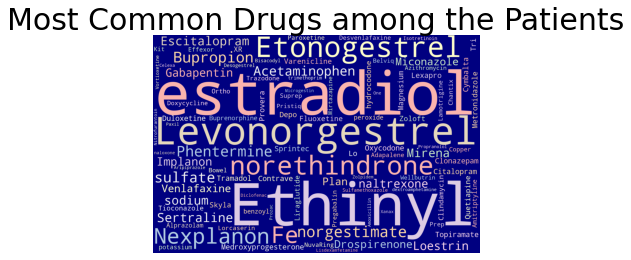

In [12]:
stopwords = set(STOPWORDS)
textString=listToString(data["drugName"])
wordcloud = WordCloud(max_words = 100, width = 1500, height = 1000, random_state=1, background_color='navy', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(textString)

plt.title('Most Common Drugs among the Patients', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

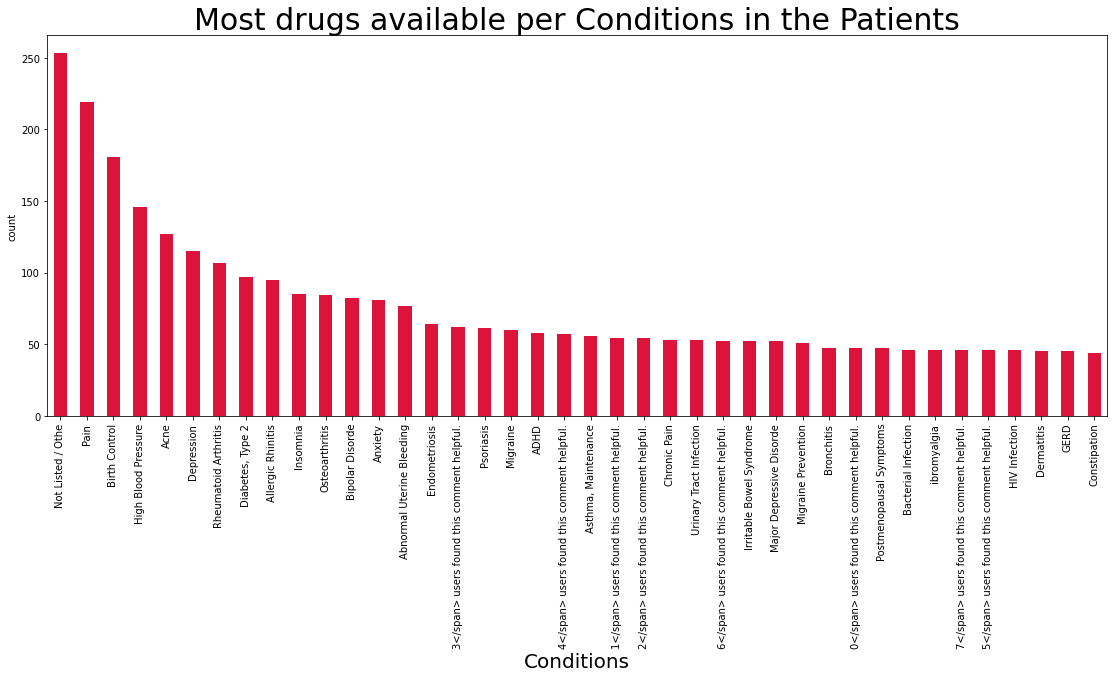

In [13]:
data.groupby(['condition'])['drugName'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'crimson')
plt.title('Most drugs available per Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

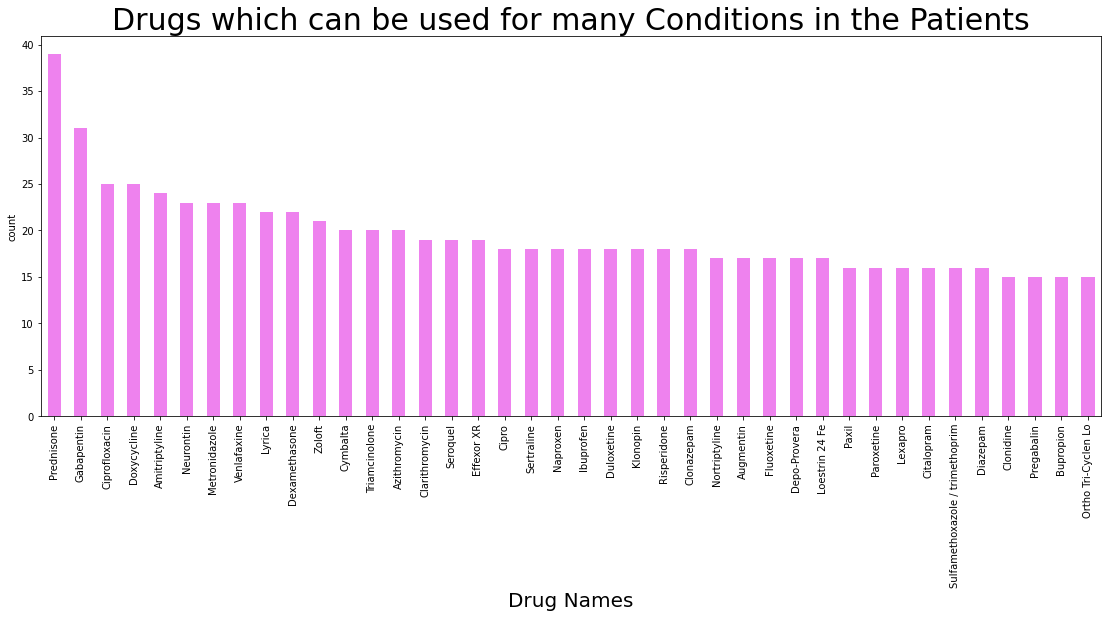

In [14]:
# checking the most popular drugs per conditions

data.groupby(['drugName'])['condition'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'violet')
plt.title('Drugs which can be used for many Conditions in the Patients', fontsize = 30)
plt.xlabel('Drug Names', fontsize = 20)
plt.ylabel('count')
plt.show()

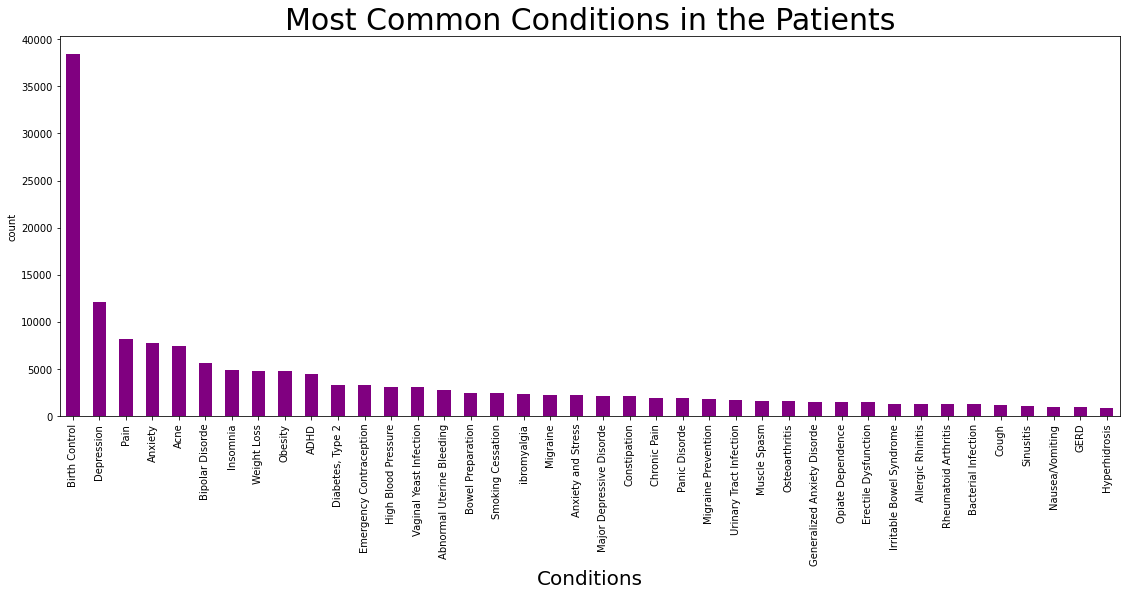

In [15]:
# checking the different types of conditions patients

data['condition'].value_counts().head(40).plot.bar(figsize = (19, 7), color = 'purple')
plt.title('Most Common Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

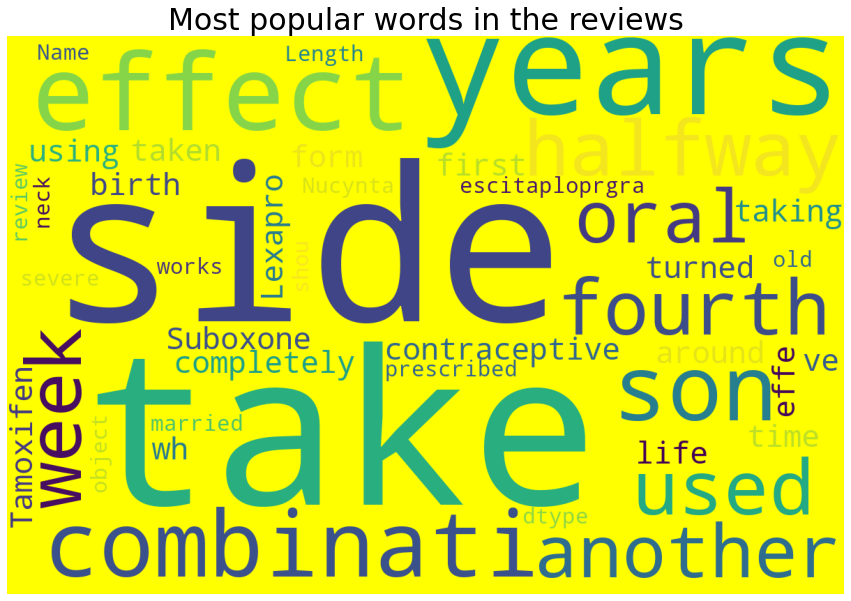

In [16]:
wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1200, height = 800).generate(str(data['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most popular words in the reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [17]:
data['rating'].value_counts()

10    68005
9     36708
1     28918
8     25046
7     12547
5     10723
2      9265
3      8718
6      8462
4      6671
Name: rating, dtype: int64

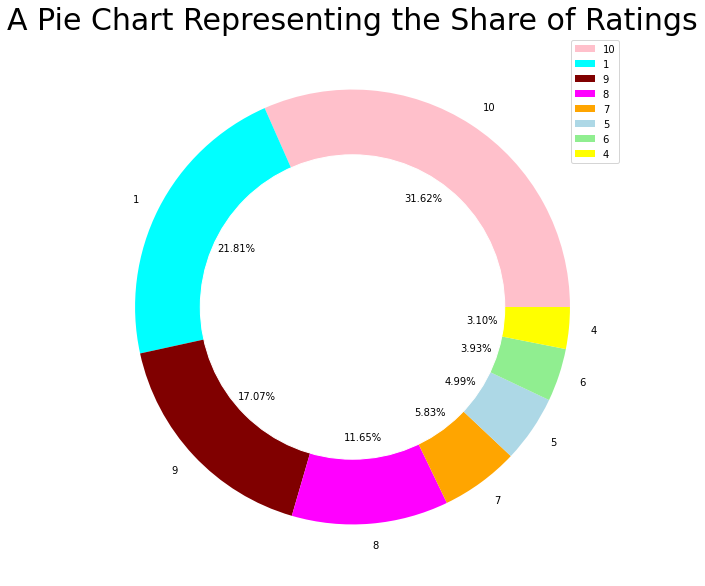

In [18]:
size = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671]
colors = ['pink', 'cyan', 'maroon',  'magenta', 'orange', 'lightblue', 'lightgreen', 'yellow']
labels = "10", "1", "9", "8", "7", "5", "6", "4"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Ratings', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

Add review sentiment column which acts as target variable. It gives a (good,bad)-(1,0) value based on rating of the drug

In [19]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 7), 'Review_Sentiment'] = 2
data.loc[(data['rating']== 5), 'Review_Sentiment'] = 1
data.loc[(data['rating']== 6), 'Review_Sentiment'] = 1
data.loc[(data['rating']<5), 'Review_Sentiment'] = 0
data['Review_Sentiment'].value_counts()

2.0    142306
0.0     53572
1.0     19185
Name: Review_Sentiment, dtype: int64

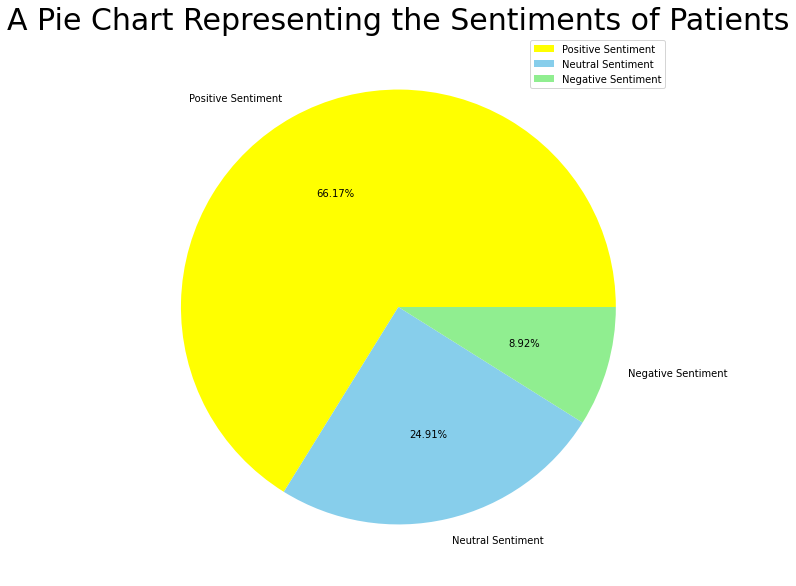

In [20]:
size = [142306,53572,19185]
colors = ['yellow', 'skyblue','lightgreen']
labels = "Positive Sentiment","Neutral Sentiment","Negative Sentiment"
#explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels,  autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Sentiments of Patients', fontsize = 30)
plt.legend()
plt.show()

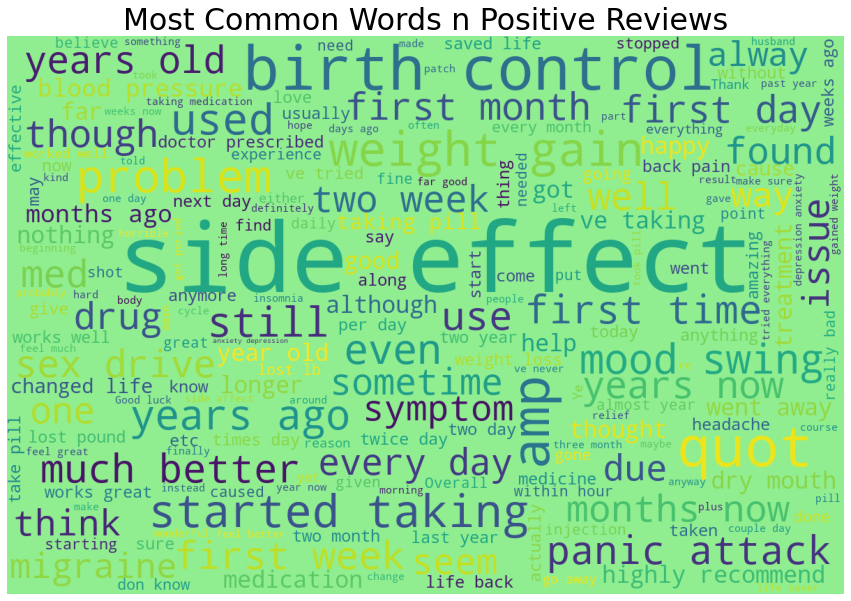

In [21]:
# making Words cloud for the postive sentiments

positive_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'lightgreen', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words n Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

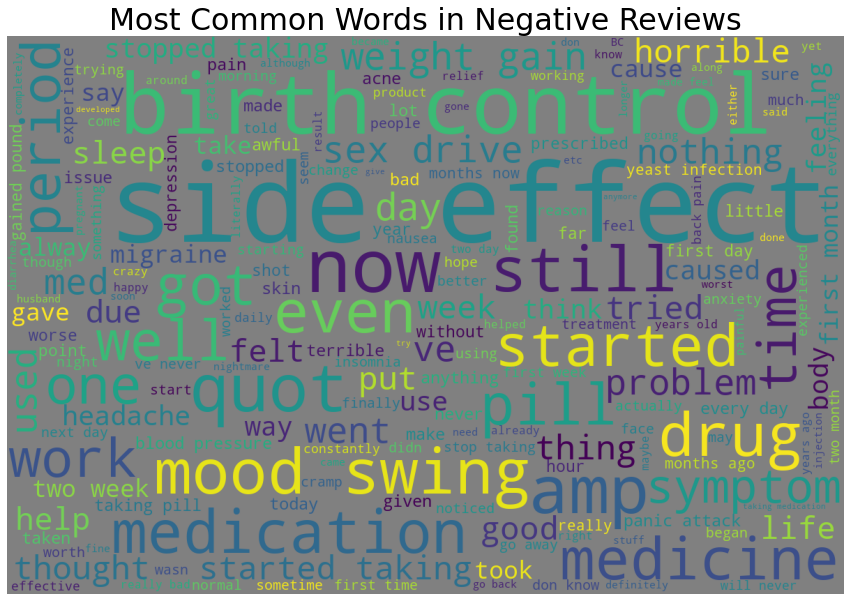

In [22]:
negative_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 0]])
wordcloud = WordCloud(background_color = 'grey', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

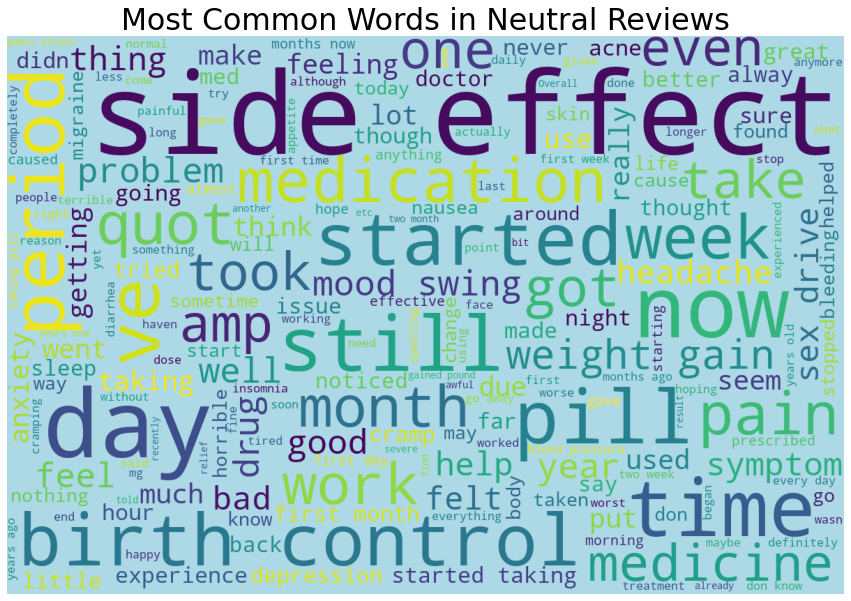

In [23]:
neutral_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 1]])
wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(neutral_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Neutral Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Extracting year,month and day from the date column

In [24]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


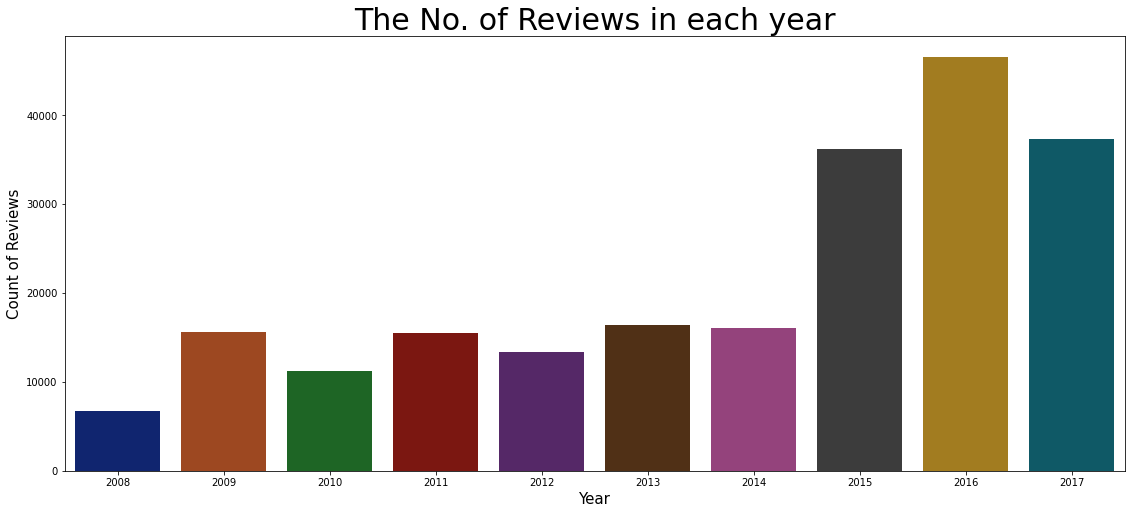

In [25]:
# looking at the no. of reviews in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['Year'], palette ='dark')
plt.title('The No. of Reviews in each year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

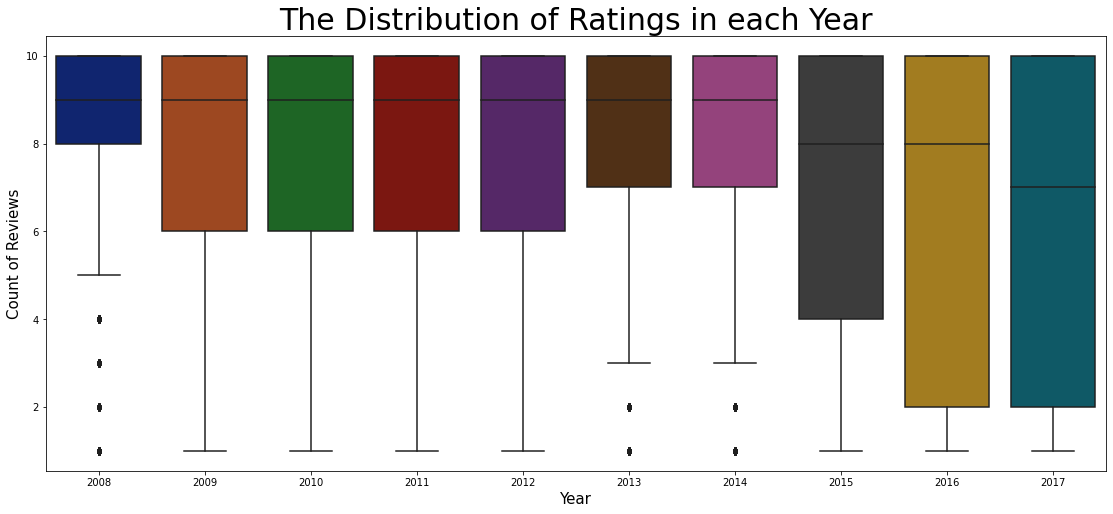

In [26]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['Year'], y = data['rating'], palette ='dark')
plt.title('The Distribution of Ratings in each Year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

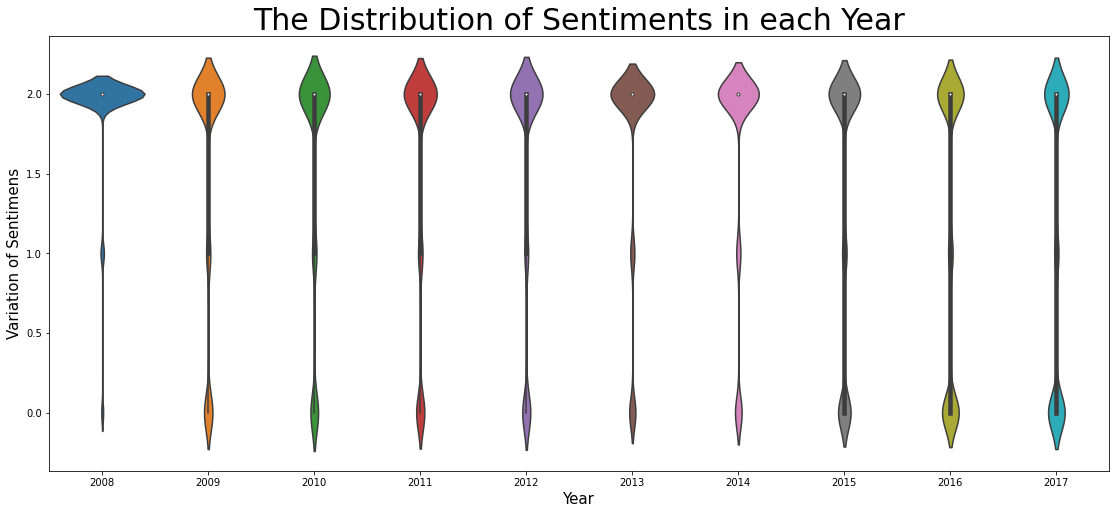

In [27]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['Year'], y = data['Review_Sentiment'])
plt.title('The Distribution of Sentiments in each Year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Variation of Sentimens', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


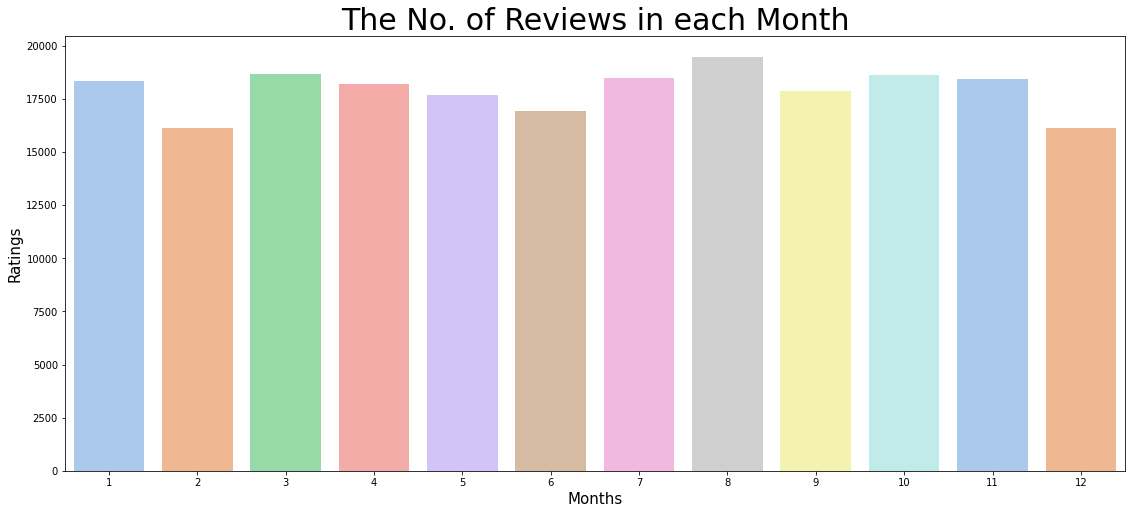

In [28]:
# looking at the no. of reviews in each of the months

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['month'], palette ='pastel')
plt.title('The No. of Reviews in each Month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.show()

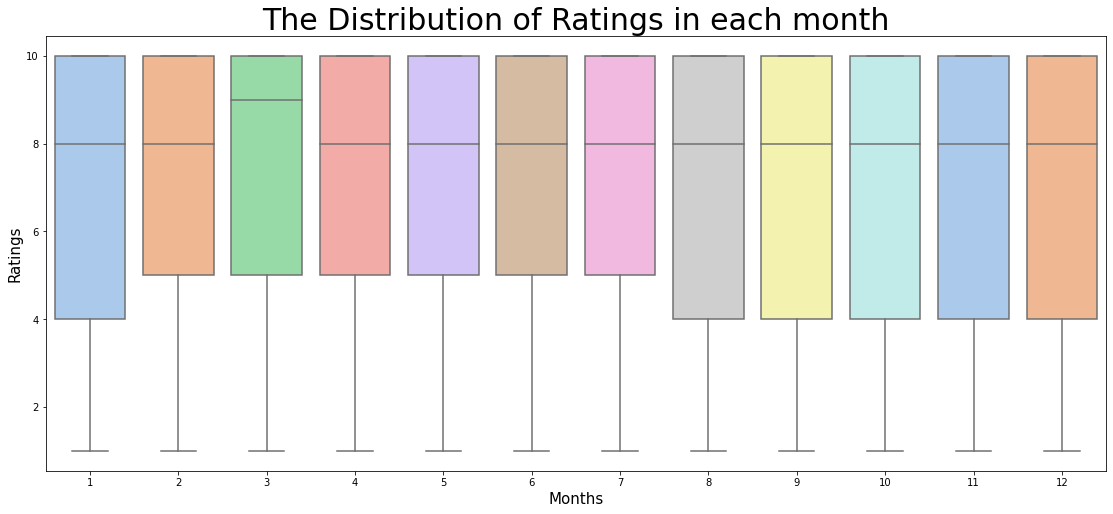

In [29]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['month'], y = data['rating'], palette ='pastel')
plt.title('The Distribution of Ratings in each month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.show()

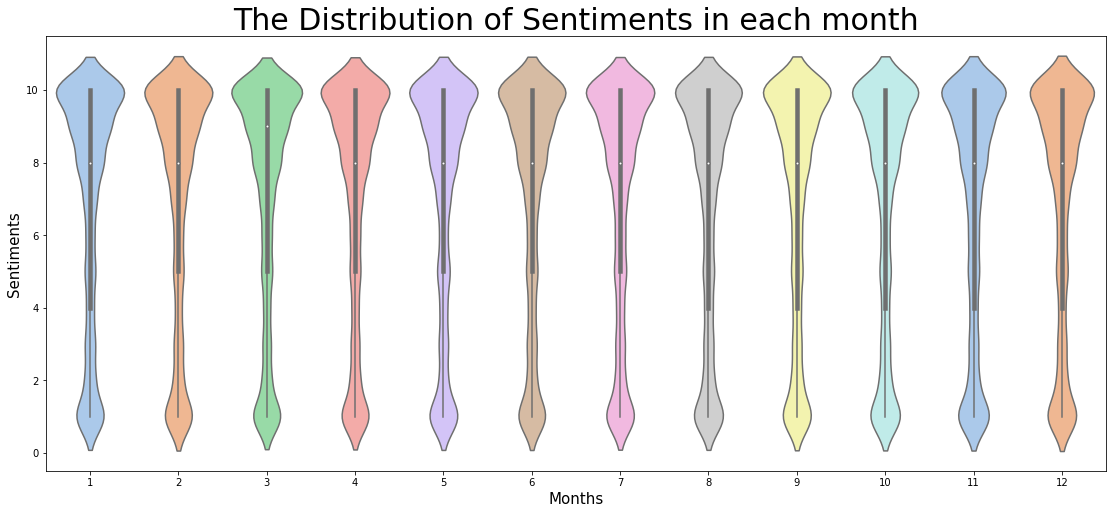

In [30]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['month'], y = data['rating'], palette ='pastel')
plt.title('The Distribution of Sentiments in each month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Sentiments', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


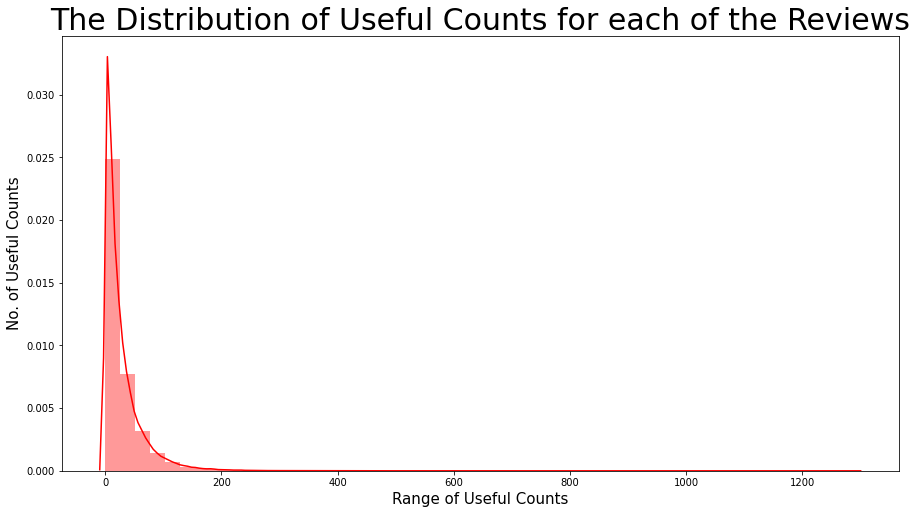

In [31]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(data['usefulCount'], color = 'red')
plt.title('The Distribution of Useful Counts for each of the Reviews', fontsize = 30)
plt.xlabel('Range of Useful Counts', fontsize = 15)
plt.ylabel('No. of Useful Counts', fontsize = 15)
plt.show()

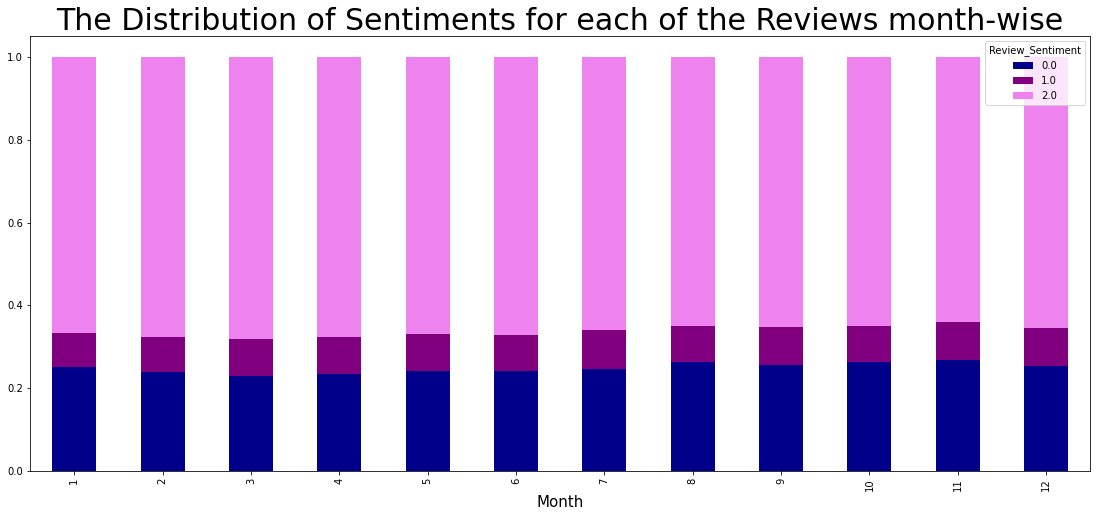

In [32]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['month'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['darkblue', 'purple', 'violet'])
plt.title('The Distribution of Sentiments for each of the Reviews month-wise', fontsize = 30)
plt.xlabel('Month', fontsize = 15)
plt.show()

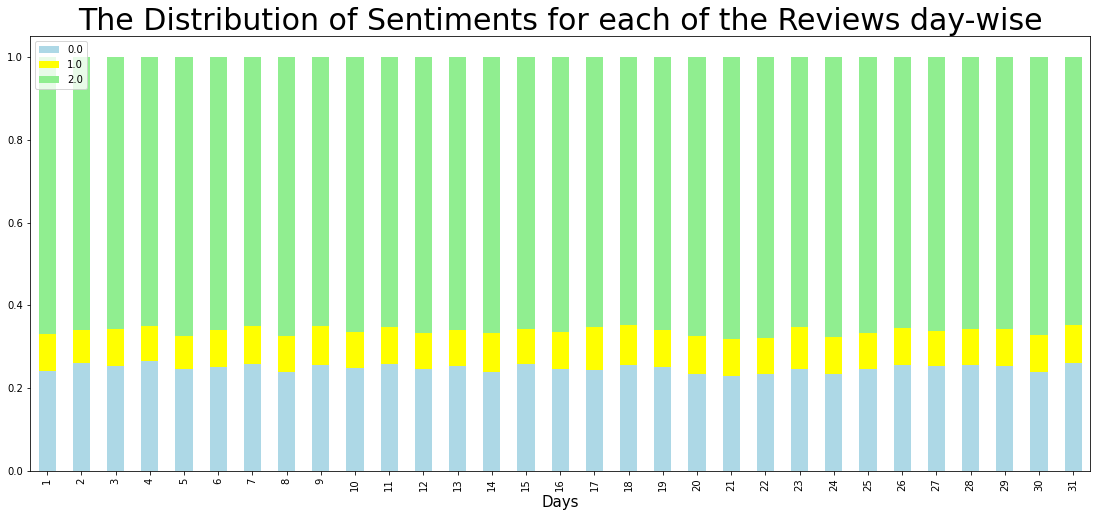

In [33]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['day'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['lightblue', 'yellow', 'lightgreen'])
plt.title('The Distribution of Sentiments for each of the Reviews day-wise', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.legend(loc = 2)
plt.show()

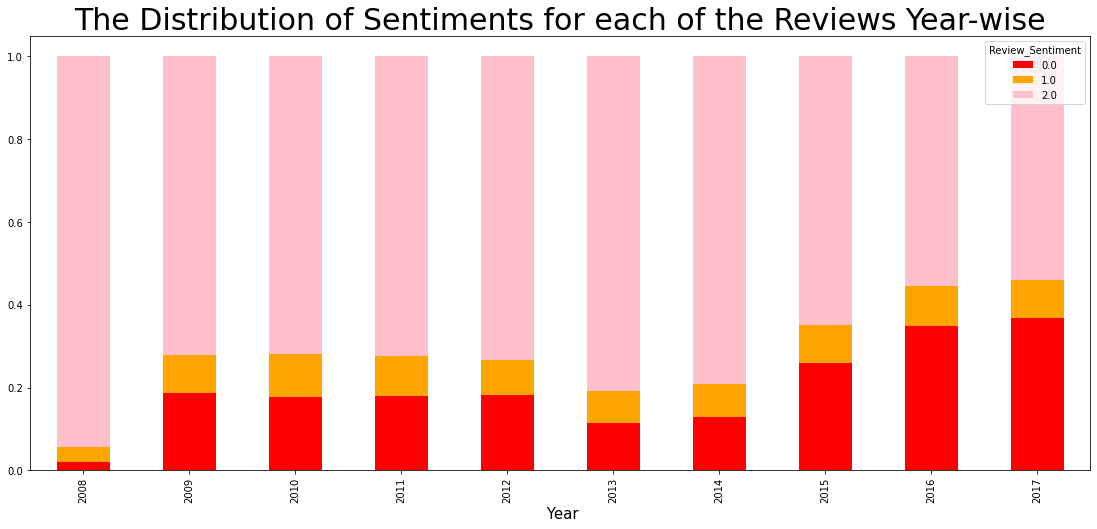

In [34]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['Year'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['red', 'orange', 'pink'])
plt.title('The Distribution of Sentiments for each of the Reviews Year-wise', fontsize = 30)
plt.xlabel(' Year', fontsize = 15)
plt.show()

([<matplotlib.axis.XTick at 0x7ff33137e250>,
 <a list of 10 Text major ticklabel objects>)

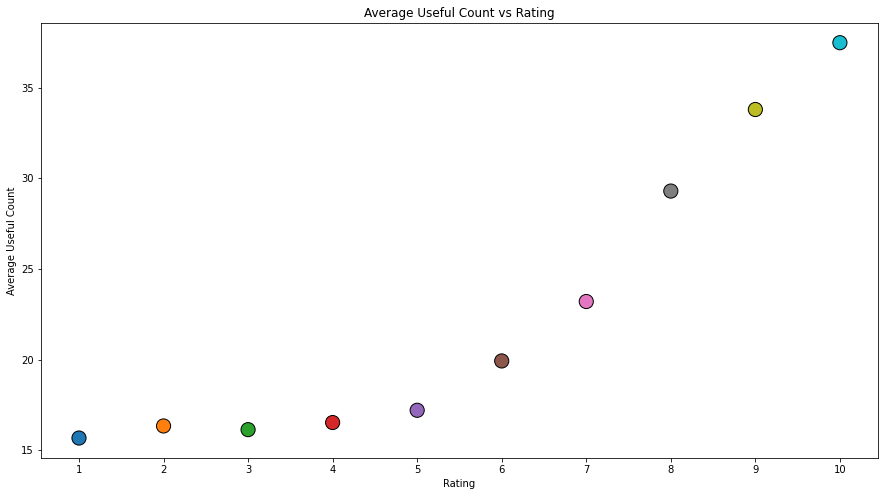

In [35]:
temp = []
for i in range(1, 11):
    temp.append([i, np.sum(data[data.rating == i].usefulCount) / np.sum([data.rating == i])]) 
temp = np.asarray(temp)

plt.scatter(temp[:, 0], temp[:, 1], c=temp[:, 0], cmap='tab10', s=200, edgecolors='k')
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)])

# Data Preprocessing

##Basic Data Info

In [36]:
data.describe()

,uniqueID,rating,usefulCount,Review_Sentiment,Year,month,day
count,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,1.412595,2013.944323,6.503076,15.657282
std,67007.913366,3.275554,36.346069,0.860559,2.711913,3.421765,8.782353
min,0.000000,1.000000,0.000000,0.000000,2008.000000,1.000000,1.000000
25%,58115.500000,5.000000,6.000000,1.000000,2012.000000,4.000000,8.000000
50%,115867.000000,8.000000,16.000000,2.000000,2015.000000,7.000000,16.000000
75%,173963.500000,10.000000,36.000000,2.000000,2016.000000,9.000000,23.000000
max,232291.000000,10.000000,1291.000000,2.000000,2017.000000,12.000000,31.000000


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   uniqueID          215063 non-null  int64         
 1   drugName          215063 non-null  object        
 2   condition         213869 non-null  object        
 3   review            215063 non-null  object        
 4   rating            215063 non-null  int64         
 5   date              215063 non-null  datetime64[ns]
 6   usefulCount       215063 non-null  int64         
 7   Review_Sentiment  215063 non-null  float64       
 8   Year              215063 non-null  int64         
 9   month             215063 non-null  int64         
 10  day               215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 24.7+ MB


Check for null values

In [38]:
data.isnull().any()

uniqueID            False
drugName            False
condition            True
review              False
rating              False
date                False
usefulCount         False
Review_Sentiment    False
Year                False
month               False
day                 False
dtype: bool

In [39]:
data['condition'].isnull().sum()

1194

In [40]:
# we will delete the rows so that the data does not overfits 

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(213869, 11)

In [41]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [43]:
data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day'],
      dtype='object')

In [44]:
df_condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
896,Short Stature,1
897,Hemangioma,1
898,Short Stature for Age,1
899,Sleep Paralysis,1
900,Gestational Diabetes,1
901,Gastric Cance,1
902,Gallbladder Disease,1
903,Dermatitis Herpetiformis,1
904,Somatoform Pain Disorde,1
905,Esophageal Variceal Hemorrhage Prophylaxis,1


Removing medical conditions which have less than 5 drug associated with it in the dataset

In [45]:
# setting a df with conditions with less than 5 drugs
df_condition_1 = df_condition[df_condition['drugName']<5].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

removing the conditions with the word "\span" in it.


In [46]:
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [47]:
data.shape

(156432, 11)

## Applying data cleanup with -


1.   Removing HTML tags
2.   Removing non letters
3.   Convert all to lower case
4.   Remove stopwords
5.   Apply stemming



In [48]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [49]:
%time data['review_clean'] = data['review'].apply(review_to_words)

CPU times: user 1min 58s, sys: 991 ms, total: 1min 59s
Wall time: 1min 59s


# Dividing into train test and applying count vectorise

Using the entire data as for test and train instead of the original breakup since all have same columns

In [50]:
df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)

# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Shape of train: (117324, 12)
Shape of test:  (39108, 12)


Making a bag of words using CountVectorise

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 5000, lowercase=True, binary=True)
# cv = CountVectorizer()
pipeline = Pipeline([('vect',cv)])

# df_train_features = pipeline.fit_transform(df_train['review_clean'])
# df_train_features = cv.fit_transform(df_train['review_clean']).toarray()
df_train_features = cv.fit_transform(df_train['review_clean'])
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("Performing Bag of Words - CountVectorise\n")
print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

Performing Bag of Words - CountVectorise

df_train_features : (117324, 5000)
df_test_features : (39108, 5000)


In [52]:
df_train_features = df_train_features.toarray()

In [53]:
df_train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day',
       'review_clean'],
      dtype='object')

In [54]:
y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']

In [55]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [56]:
y_test.shape

(39108, 3)

#Analysing Emotions

In [57]:
# Make data directory if it doesn't exist
!mkdir -p nrcdata
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/upshot-trump-emolex/data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt -P nrcdata

--2021-05-15 10:17:11--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/upshot-trump-emolex/data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2581050 (2.5M) [text/plain]
Saving to: ‘nrcdata/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt’

NRC-emotion-lexicon 100%[===================>]   2.46M  --.-KB/s    in 0.1s    

2021-05-15 10:17:11 (21.3 MB/s) - ‘nrcdata/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt’ saved [2581050/2581050]



In [58]:
filepath = "/content/nrcdata/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t', keep_default_na=False)
emolex_df.head(12)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


In [59]:
emolex_df.emotion.unique()

array(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'], dtype=object)

In [60]:
emolex_df.emotion.value_counts()

positive        14182
trust           14182
negative        14182
anticipation    14182
disgust         14182
fear            14182
anger           14182
joy             14182
surprise        14182
sadness         14182
Name: emotion, dtype: int64

In [61]:
emolex_df[emolex_df.association == 1].emotion.value_counts()

negative        3324
positive        2312
fear            1476
anger           1247
trust           1231
sadness         1191
disgust         1058
anticipation     839
joy              689
surprise         534
Name: emotion, dtype: int64

In [62]:
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_words.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


In [63]:
def extract_review_emotion(df,column):
    new_df = df.copy()
    
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions) 
    stemmer = SnowballStemmer("english")   
    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)
    return new_df

In [64]:
emotion_df = extract_review_emotion(data, 'review_clean')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [70]:
emo = emotion_df.groupby(['drugName']).sum()

In [71]:
emo.head(10)

,uniqueID,rating,usefulCount,Review_Sentiment,Year,month,day,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
drugName,,,,,,,,,,,,,,,,,
A + D Cracked Skin Relief,163935,10,6,2.0,2009,12,7,1,0,0,1,2,3,2,0,0,2
A / B Otic,131173,10,20,2.0,2009,9,23,0,1,1,2,1,4,1,2,1,1
Abacavir / dolutegravir / lamivudine,3748194,437,653,88.0,106842,341,911,25,100,52,45,50,100,132,62,22,103
Abacavir / lamivudine / zidovudine,117239,9,1,2.0,2014,9,6,0,1,0,0,0,1,0,0,1,1
Abatacept,1447899,136,976,29.0,38272,97,278,11,25,10,25,23,45,43,25,9,25
Abilify,39992508,2758,17179,556.0,849650,2829,6864,318,1025,330,695,624,1175,1121,661,406,661
Abilify Discmelt,240464,16,19,4.0,4021,6,35,0,1,0,0,0,0,0,0,0,0
Abilify Maintena,750287,31,27,6.0,8064,24,46,6,11,5,7,8,10,12,7,8,8
Abiraterone,1699270,82,360,16.0,18125,64,152,3,5,4,6,3,10,8,6,3,3


In [73]:
emo.to_csv('emotion_groupby11.csv',index=True)

In [69]:
emotion_df.to_csv('emotion_sentiment.csv',index=False)